# Animal recognition for self driving cars

In [1]:
# say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras
from keras import metrics

from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# split between train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Since we just need to distinguish between animals and vehicles (we do not need to be so specific using "airplane", "truck", "deer", "dog", etc), I decided to create two macro groups, turning the request into a binary prediction problem.

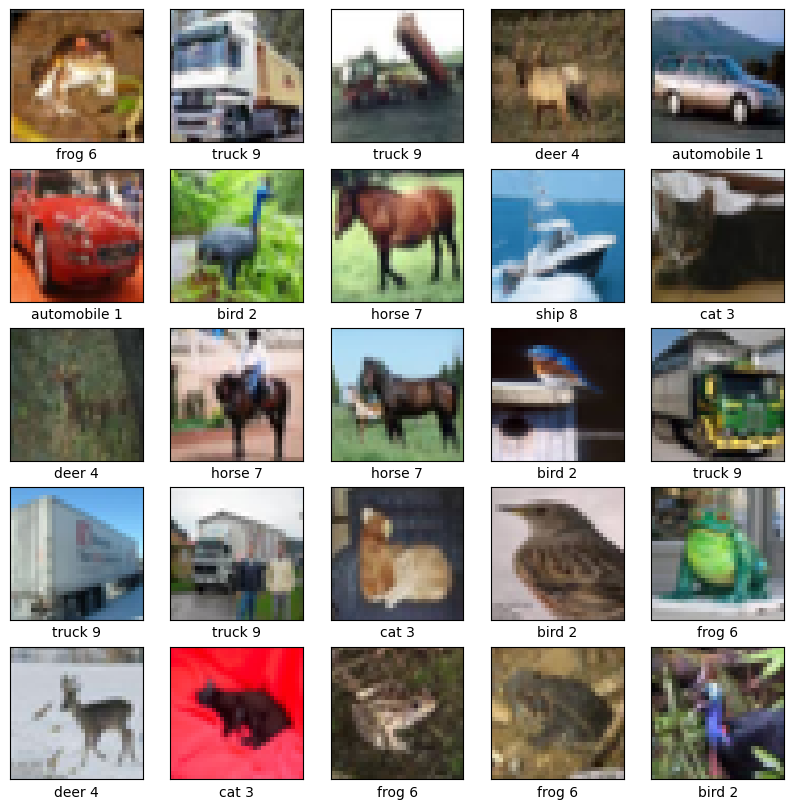

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

vehicles = [0, 1, 8, 9]  # airplane, automobile, ship, truck
animals = [2, 3, 4, 5, 6, 7]  # bird, cat, deer, dog, frog, horse

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i][0]] + ' ' + str(y_train[i][0]))
plt.show()

y_train_binary = np.where(np.isin(y_train, animals), 1, 0).flatten()
y_test_binary = np.where(np.isin(y_test, animals), 1, 0).flatten()

# The original y_test from cifar10 has shape = (10000, 1) (a column).
# np.where returns an array with the same shape as y_test, so (10000, 1).
# But for binary_crossentropy in Keras the labels must be in 1D format. For this reason, I used .flatten()

In [5]:
clear_session()
cnn = Sequential([
    InputLayer(input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Flatten(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')

])

cnn.compile(optimizer="adam",
             loss = "binary_crossentropy",
             metrics=["accuracy", tf.keras.metrics.Precision(name="precision")])

# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision


In [6]:
# here I modify the images in a randomic way. This will help the CNN to learn better

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train_binary, batch_size)

In [7]:
%%time
hist = cnn.fit(train_generator, epochs=10, validation_data=(X_test, y_test_binary))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - accuracy: 0.8613 - loss: 0.3514 - precision: 0.8817 - val_accuracy: 0.8762 - val_loss: 0.2980 - val_precision: 0.9670
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9137 - loss: 0.2132 - precision: 0.9221 - val_accuracy: 0.9323 - val_loss: 0.1678 - val_precision: 0.9245
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9275 - loss: 0.1868 - precision: 0.9341 - val_accuracy: 0.9059 - val_loss: 0.2281 - val_precision: 0.9612
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.9348 - loss: 0.1671 - precision: 0.9395 - val_accuracy: 0.8909 - val_loss: 0.2661 - val_precision: 0.8534
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9408 - loss: 0.1549 - precision: 0.9454 - val_accuracy: 0.9446 - val_loss: 0.1415 - val_precision: 0.9640
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9450 - loss: 0.1447 - precision: 0.9501 - val_accu

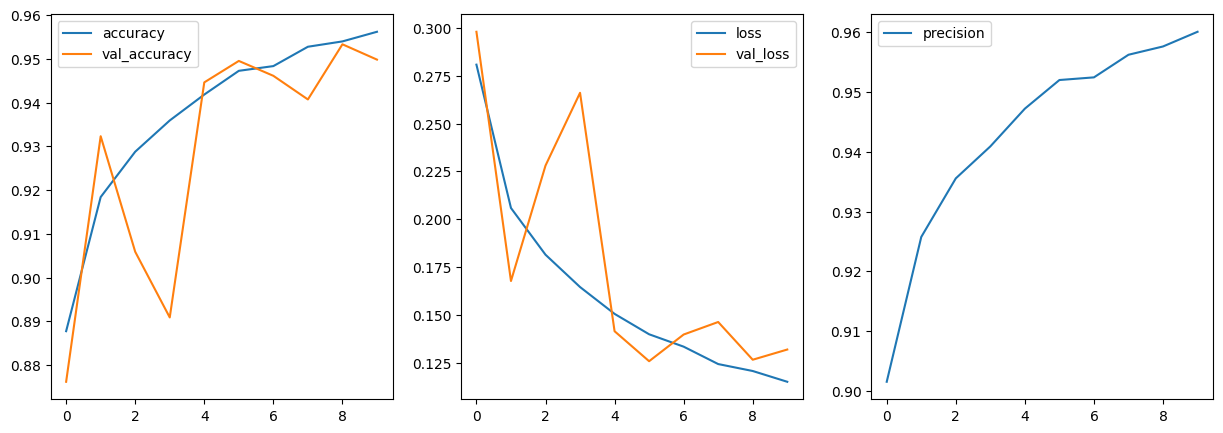

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.subplot(1,3,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1,3,3)
plt.plot(hist.history['precision'], label='precision')
plt.legend()


Even though the val_accuracy and the val_loss have some "hiccups", the trends are good since we have an increase of the accuracy and a decrease of the loss. Along the epochs, we have an increase of the precision too and this is exactly what we need from our model.

To understand which is the class that the model misses more, I decided to use a confusion matrix + heatmap

https://www.tensorflow.org/tutorials/video/video_classification

In [9]:
predictions = cnn.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


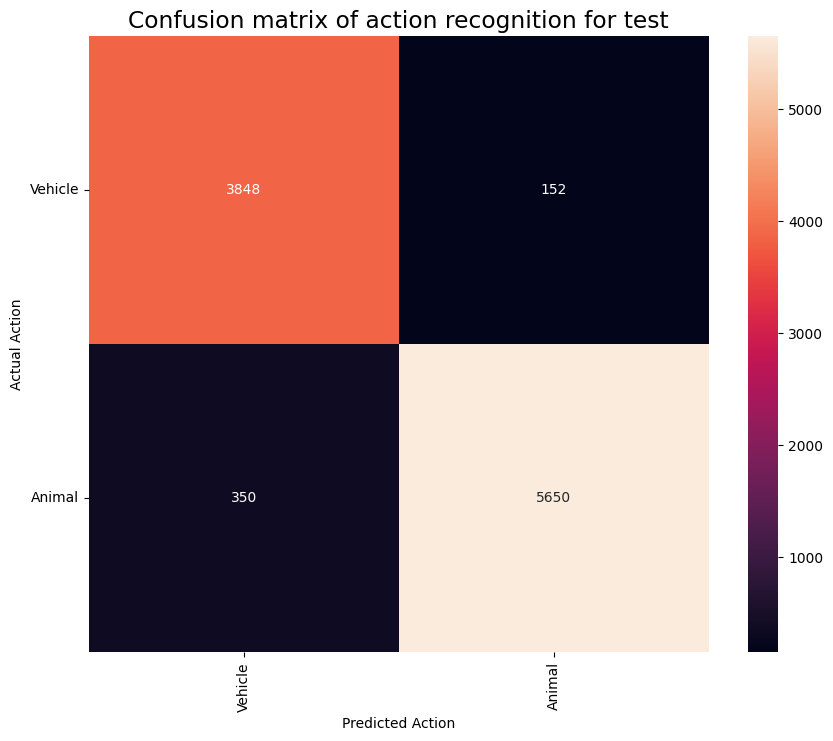

In [10]:
preds = (predictions > 0.5).astype(int).flatten()

from matplotlib.pyplot import figure
figure(figsize=(10, 8))

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

labels = ["Vehicle", "Animal"]

plot_confusion_matrix(y_test_binary, preds, labels, 'test')

There is an unbalance between vehicles and animals. For this reason, a bigger set of vehicles images could help the model to classify better.